<a href="https://colab.research.google.com/github/ceroytres/tutorials/blob/zca/source/zca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ZCA Whitening

The following tutorial will show you how to perform ZCA data whitening on a dataset using ```kornia.enhance.zca```. The documentation for ZCA whitening can be found [here](https://kornia.readthedocs.io/en/latest/enhance.html#kornia.enhance.ZCAWhitening).



## Install necessary packages


In [1]:
%%capture
!pip install kornia numpy matplotlib

In [2]:
#Import required libraries
import matplotlib.pyplot as plt
import numpy as np

import torch
import kornia as K

from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [3]:
# Select runtime device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda:0


## ZCA on MNIST

Download and load the MNIST dataset.

In [4]:
%%capture
dataset = datasets.MNIST('./data/mnist', train=True, download=True, 
                         transform=transforms.Compose([transforms.ToTensor()])) 

Stack whole dataset in order to fit ZCA on whole dataset.

In [5]:
images = []
for i in range(len(dataset)):
  im, _ = dataset[i]
  images.append(im) 
images = torch.stack(images, dim = 0).to(device)

Create an ZCA object and fit the transformation in the forward pass. Setting ```include_fit``` is necessary if you need to include the ZCA fitting processing the backwards pass.

In [6]:
zca = K.enhance.ZCAWhitening(eps=0.1)
images_zca = zca(images, include_fit = True)

The result shown should enhance the edges of the MNIST digits because the regularization parameter $\epsilon$ increases the importance of the higher frequencies which typically correspond to the lowest eigenvalues in ZCA. The result looks similar to the demo from the [Stanford ZCA tutorial](http://ufldl.stanford.edu/tutorial/unsupervised/ExercisePCAWhitening/)

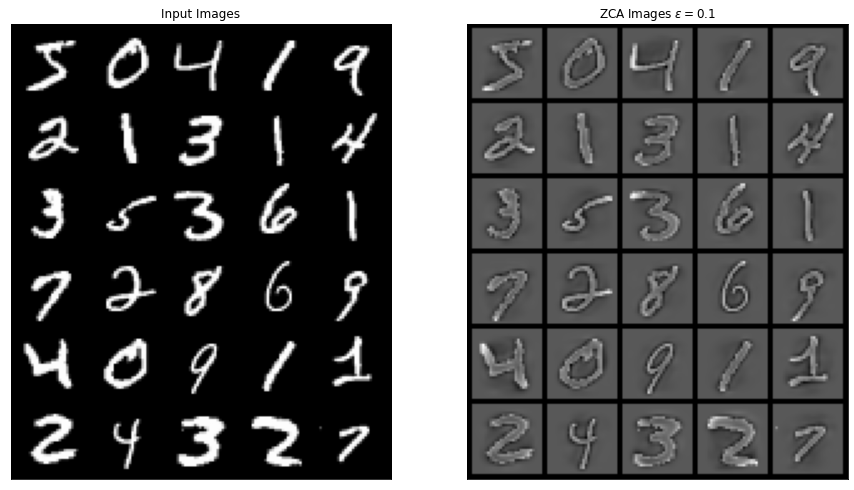

In [7]:
grid_im = make_grid(images[0:30], nrow=5, normalize=True).cpu().numpy()
grid_zca = make_grid(images_zca[0:30], nrow=5, normalize=True).cpu().numpy()


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.transpose(grid_im,[1,2,0]))
plt.title('Input Images')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(np.transpose(grid_zca,[1,2,0]))
plt.title(r'ZCA Images $\epsilon = 0.1$')
plt.xticks([])
plt.yticks([])
plt.show()

## ZCA on CIFAR-10


In the next example, we explore using ZCA on the CIFAR 10 dataset, which is a dataset of color images (e.g 4-D tensor $[B, C, H, W]$). In the cell below, we prepare the dataset.

In [8]:
%%capture
dataset = datasets.CIFAR10('./data/cifar', train=True, download=True, 
                         transform=transforms.Compose([transforms.ToTensor()]))
images = []
for i in range(len(dataset)):
  im, _ = dataset[i]
  images.append(im) 
images = torch.stack(images, dim = 0).to(device) 

We show another way to fit the ZCA transform using the ```fit``` method useful when ZCA is included in [data augumentation pipelines](https://kornia.readthedocs.io/en/latest/tutorials/data_augmentation.html). Also if ```compute_inv = True```, this enables the computation of inverse ZCA transform in case a reconstruction is required.

In [9]:
zca = K.enhance.ZCAWhitening(eps=0.1, compute_inv=True)
zca.fit(images)
zca_images = zca(images)
image_re = zca.inverse_transform(zca_images)

Note how the higher frequency details are more present in the ZCA normalized images for CIFAR-10 dataset.

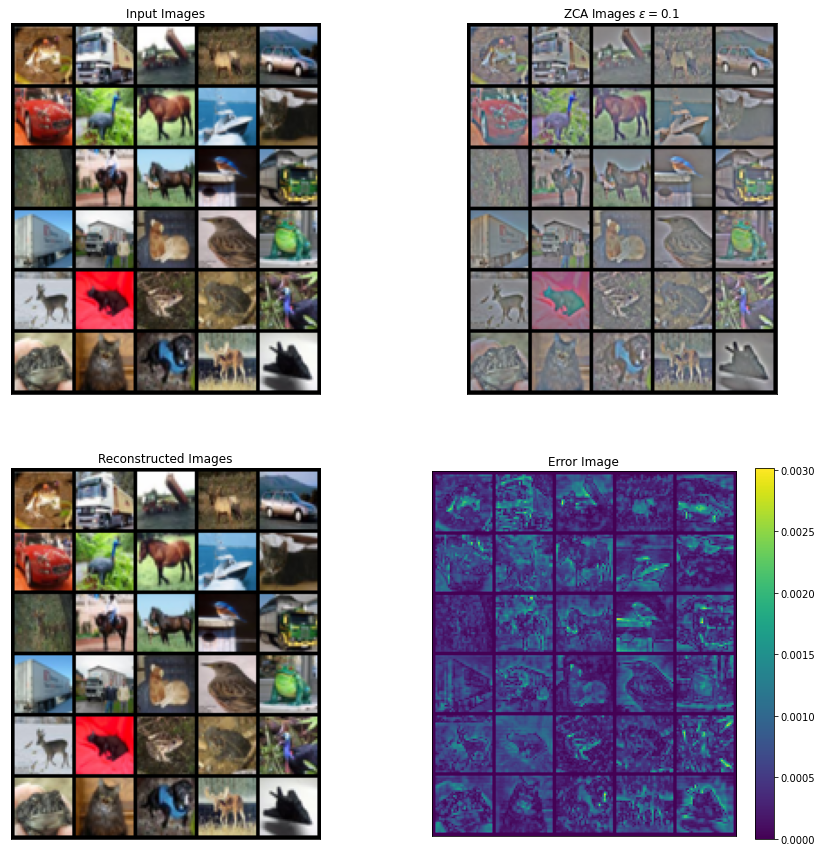

In [10]:
grid_im = make_grid(images[0:30], nrow=5, normalize=True).cpu().numpy()
grid_zca = make_grid(zca_images[0:30], nrow=5, normalize=True).cpu().numpy()
grid_re= make_grid(image_re[0:30], nrow=5, normalize=True).cpu().numpy()


err_grid= grid_re - grid_im # Compute error image

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(np.transpose(grid_im,[1,2,0]))
plt.title('Input Images')
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,2)
plt.imshow(np.transpose(grid_zca,[1,2,0]))
plt.title(r'ZCA Images $\epsilon = 0.1$')
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,3)
plt.imshow(np.transpose(grid_re,[1,2,0]))
plt.title(r'Reconstructed Images')
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,4)
plt.imshow(np.sum(abs(np.transpose(err_grid,[1,2,0])), axis = -1))
plt.colorbar()
plt.title('Error Image')
plt.xticks([])
plt.yticks([])
plt.show()

## Differentiability of ZCA 

We will as simple Gaussian dataset with a mean (3,3) and a diagonal covariance of 1 and 9 to explore the differentiability of ZCA.

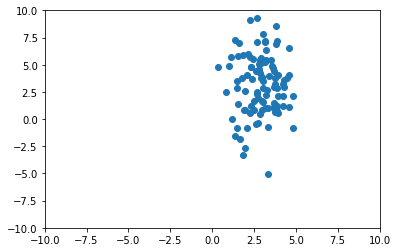

In [11]:
num_data = 100 #Number of points in the dataset
torch.manual_seed(1234)
x = torch.cat([torch.randn((num_data,1), requires_grad=True),
               3 * torch.randn((num_data,1), requires_grad=True)], dim=1) + 3

plt.scatter(x.detach().numpy()[:,0],x.detach().numpy()[:,1])
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

Here we explore the affect of the `detach_transform` option when computing the backwards pass.

In [12]:
zca_detach = K.enhance.ZCAWhitening(eps=1e-6, detach_transforms=True)
zca_grad = K.enhance.ZCAWhitening(eps=1e-6, detach_transforms=False)

As a sanity check, the Jacobian between the input and output of the ZCA transform should be same for all data points in the detached case since the transform acts as linear transform (e.g $T(X-\mu)$). In the non-detached case, the Jacobian should vary across datapoints since the input affects the computation of the ZCA transformation matrix (e.g. $T(X)(X-\mu(X))$). As the number of samples increases, the Jacobians in the detached and non-detached cases should be roughly the same since the influence of a single datapoint decreases. You can test this by changing ```num_data``` . Also note that ```include_fit=True``` is included in the forward pass since creation of the transform matrix needs to be included in the forward pass in order to correctly compute the backwards pass. 

In [13]:
import torch.autograd as autograd

J = autograd.functional.jacobian(lambda x: zca_detach(x, include_fit=True), x)

num_disp = 5
print(f'Jacobian matrices detached for the first {num_disp} points')
for i in range(num_disp):
  print(J[i,:,i,:])

print('\n')

J = autograd.functional.jacobian(lambda x: zca_grad(x, include_fit=True), x)
print(f'Jacobian matrices attached for the first {num_disp} points')
for i in range(num_disp):
  print(J[i,:,i,:])

Jacobian matrices detached for the first 5 points
tensor([[ 1.0177, -0.0018],
        [-0.0018,  0.3618]])
tensor([[ 1.0177, -0.0018],
        [-0.0018,  0.3618]])
tensor([[ 1.0177, -0.0018],
        [-0.0018,  0.3618]])
tensor([[ 1.0177, -0.0018],
        [-0.0018,  0.3618]])
tensor([[ 1.0177, -0.0018],
        [-0.0018,  0.3618]])


Jacobian matrices attached for the first 5 points
tensor([[ 1.0003, -0.0018],
        [-0.0018,  0.3547]])
tensor([[ 1.0006, -0.0027],
        [-0.0027,  0.3555]])
tensor([[ 0.9911, -0.0028],
        [-0.0028,  0.3506]])
tensor([[9.9281e-01, 4.4671e-04],
        [4.4671e-04, 3.5368e-01]])
tensor([[ 1.0072, -0.0019],
        [-0.0019,  0.3581]])


Lastly, we plot the ZCA whitened data. Note that setting the `include_fit` to `True` stores the resulting transformations for future use.

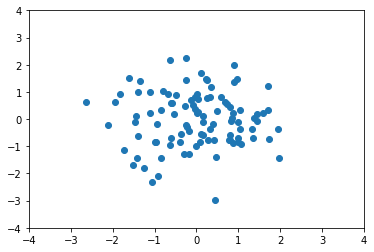

In [14]:
x_zca = zca_detach(x).detach().numpy()
plt.scatter(x_zca[:,0], x_zca[:,1])
plt.ylim([-4,4])
plt.xlim([-4,4])
plt.show()